In [1]:
!pip install plotly folium --quiet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium


In [7]:
from google.colab import files
uploaded = files.upload()

# Read the CSV file (update the file name if needed)



Saving AB_NYC_2019.csv to AB_NYC_2019.csv


In [8]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [9]:
df.info()
df.isnull().sum()

# Drop rows with missing values
df = df.dropna()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Text(0.5, 1.0, 'Number of Listings by Borough')

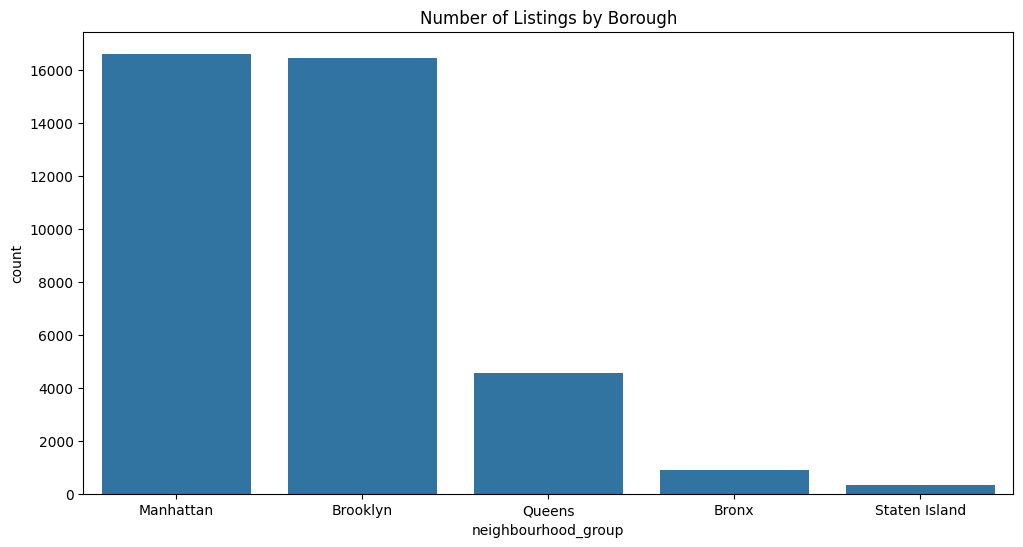

In [10]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='neighbourhood_group', order=df['neighbourhood_group'].value_counts().index)
plt.title('Number of Listings by Borough')


Text(0.5, 1.0, 'Average Airbnb Price by Borough')

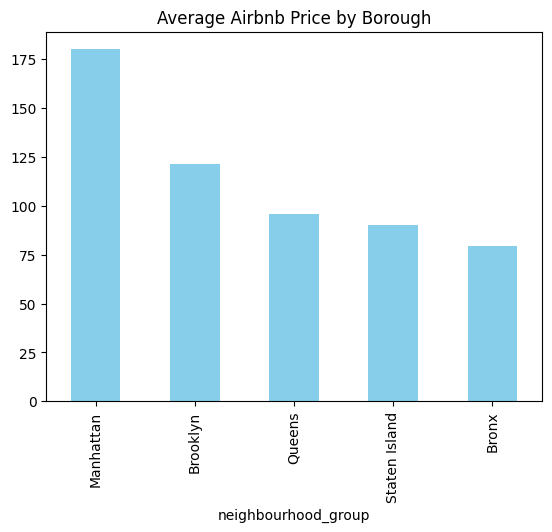

In [11]:
df.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Average Airbnb Price by Borough')


Text(0.5, 1.0, 'Distribution of Room Types')

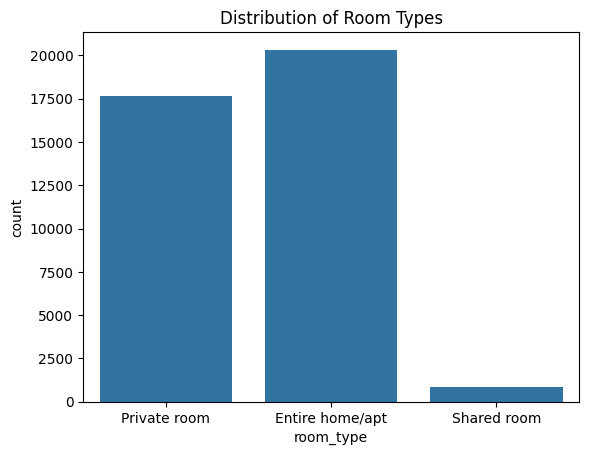

In [12]:
sns.countplot(data=df, x='room_type')
plt.title('Distribution of Room Types')


In [13]:
map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
for lat, lon in zip(df['latitude'][:1000], df['longitude'][:1000]):
    folium.CircleMarker([lat, lon], radius=1, color='red').add_to(map)
map


In [15]:
fig = px.scatter(
    df[:1000], x='longitude', y='latitude',
    color='price', size='price',
    hover_data=['name', 'neighbourhood', 'room_type']
)
fig.show()


In [16]:
!pip install xgboost --quiet


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Make a copy
df_model = df.copy()

# Drop unnecessary columns
df_model = df_model.drop(['name', 'host_name', 'last_review', 'reviews_per_month'], axis=1)

# Remove extreme outliers
df_model = df_model[(df_model['price'] > 0) & (df_model['price'] < 1000)]

# One-hot encode categorical columns
df_model = pd.get_dummies(df_model, columns=['neighbourhood_group', 'room_type'], drop_first=True)

# Drop unused columns
df_model = df_model.drop(['neighbourhood', 'latitude', 'longitude'], axis=1)

df_model.head()


,id,host_id,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
0,2539,2787,149,1,9,6,365,True,False,False,False,True,False
1,2595,2845,225,1,45,2,355,False,True,False,False,False,False
3,3831,4869,89,1,270,1,194,True,False,False,False,False,False
4,5022,7192,80,10,9,1,0,False,True,False,False,False,False
5,5099,7322,200,3,74,1,129,False,True,False,False,False,False


In [18]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features and target
X = df_model.drop('price', axis=1)
y = df_model['price']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DMatrix (optimized format for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}

# Train
model = xgb.train(params, dtrain, num_boost_round=100)

# Predict
y_pred = model.predict(dtest)


In [20]:
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", rmse)



R² Score: 0.4126070737838745
MAE: 47.32427978515625
RMSE: 82.65214722804393


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

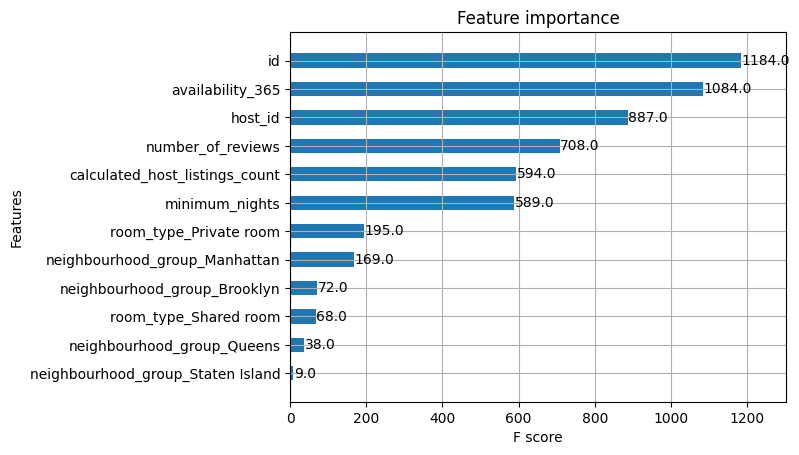

In [21]:
xgb.plot_importance(model, height=0.5)
